# Vision Larguage Models Transformers

## CLIP - Contrastive Language–Image Pretraining

CLIP is a neural network adept at grasping visual concepts through natural language supervision. It trains a text encoder and an image encoder together to match captions with images. 

This design allows CLIP to perform well on different visual classification tasks without additional training, similar to the "zero-shot" learning seen in GPT-3 models. It can recognize visual categories just by receiving their names.

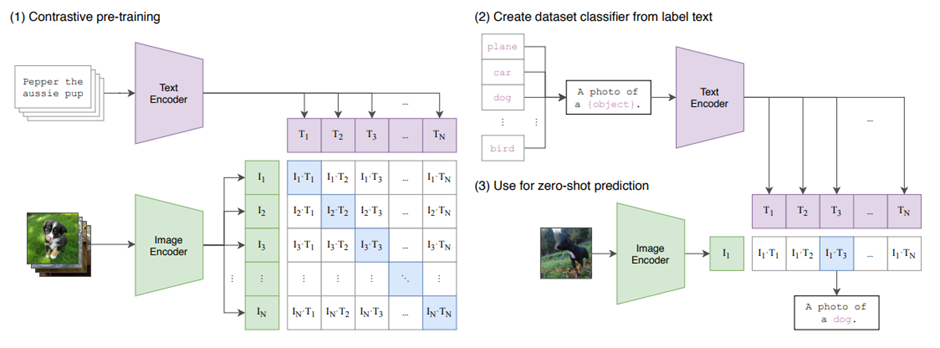

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    text=["a photo of a cat", "a photo of a dog"],
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# Multimodal Text Generation (BLIP)

In [ ]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16
)
model.to(device)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

prompt = "Question: How many remotes are there? Answer:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(
    device, torch.float16
)
outputs = model.generate(**inputs)
text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(text)

# Multimodal Object Detection (OWL-ViT)

Object detection, a crucial aspect of computer vision, has progressed notably with models such as YOLO. Yet, conventional models like YOLO encounter challenges in detecting objects that differ significantly from those in their training data.

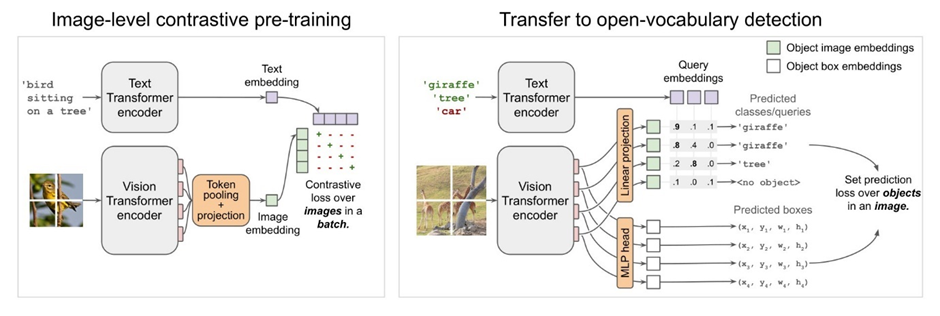

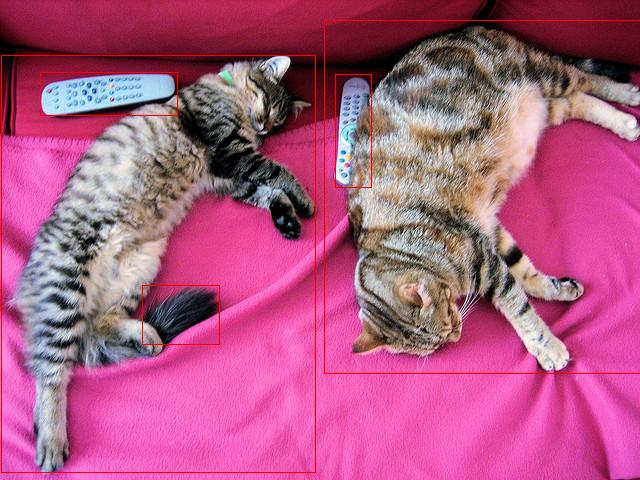

In [ ]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a cat", "a photo of a dog", "remote control", "cat tail"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1
)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Create a draw object
draw = ImageDraw.Draw(image)

# Draw each bounding box
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}"
    )
    # Draw the bounding box on the image
    draw.rectangle(box, outline="red")

# Display the image
image